<a href="https://colab.research.google.com/github/ziri4k/ML---Prediction-of-Stress-in-Wind-Turbine-WASPALOY-/blob/main/WASPALOYmain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WASAPALOY FOR AIRCRAFT TURBINE


this is to predict stress that will result to break of the alloy

In [ ]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


In [ ]:
#The data is fed into
uploaded = files.upload()
dataset = pd.read_csv("newproj2.csv")
df= dataset

Saving newproj2.csv to newproj2.csv


In [ ]:
dataset.head()


,strain,temperature,strainrate,stress
0,0.00,-180,4000,717
1,0.05,-180,4000,910
2,0.10,-180,4000,1051
3,0.15,-180,4000,1152
4,0.20,-180,4000,1221


In [ ]:
dataset.tail()

,strain,temperature,strainrate,stress
237,0.30,750,7500,743
238,0.35,750,7500,753
239,0.40,750,7500,750
240,0.45,750,7500,738
241,0.50,750,7500,719


SPLIT INTO TRAIN AND TEST SET

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Inspect the data

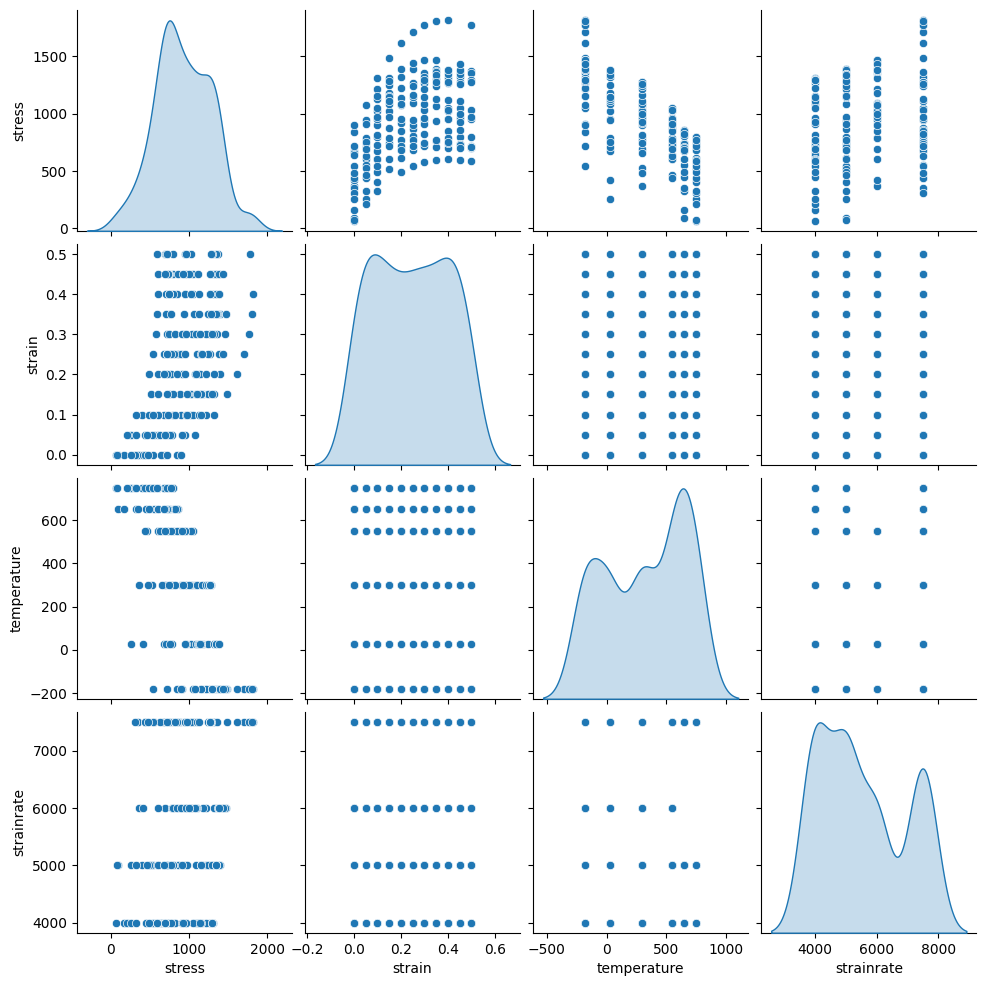

In [ ]:
sns.pairplot(train_dataset[['stress', 'strain', 'temperature', 'strainrate']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
strain,194.0,0.244588,0.158471,0.0,0.10,0.25,0.4,0.5
temperature,194.0,322.783505,336.036768,-180.0,25.00,300.00,650.0,750.0
strainrate,194.0,5530.927835,1346.294921,4000.0,4000.00,5000.00,7500.0,7500.0
stress,194.0,923.783505,354.356023,66.0,699.75,909.50,1212.5,1817.0


Split features from labels

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('stress')
test_labels = test_features.pop('stress')

**Normalization**

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
strain,0.244588,0.158471
temperature,322.783505,336.036768
strainrate,5530.927835,1346.294921
stress,923.783505,354.356023


create new layer

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

fit the state of the preprocessing layer

In [ ]:
normalizer.adapt(np.array(train_features))

mean and variance and store them in the layer

In [ ]:
print(normalizer.mean.numpy())

[[   0.245  322.784 5530.928]]


when called returns input data with normalized

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   0.  650. 5000.]]

Normalized: [[-1.55  0.98 -0.4 ]]


Build the Keras Sequential model

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.1))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=1700)

CPU times: user 46.6 s, sys: 1.97 s, total: 48.6 s
Wall time: 54.1 s


visualizing model training progress

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
1695,22.570103,49.163425,1695
1696,16.707499,53.017529,1696
1697,13.854816,53.584099,1697
1698,13.931773,51.222237,1698
1699,15.253555,52.272476,1699


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 700])
  plt.xlabel('Epoch')
  plt.ylabel('Error [stress]')
  plt.legend()
  plt.grid(True)

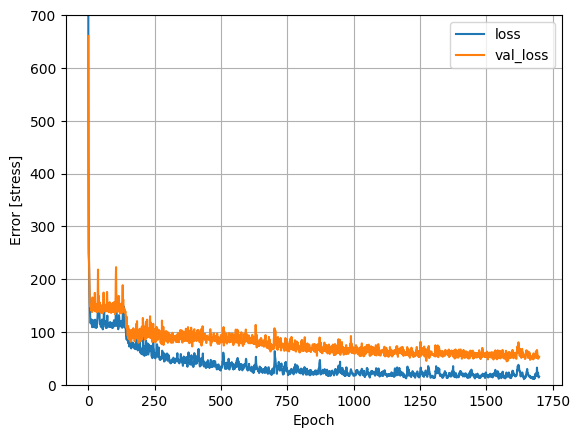

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [stress]']).T

,Mean absolute error [stress]
dnn_model,36.608215


Stress

2/2 [==============================] - 0s 4ms/step


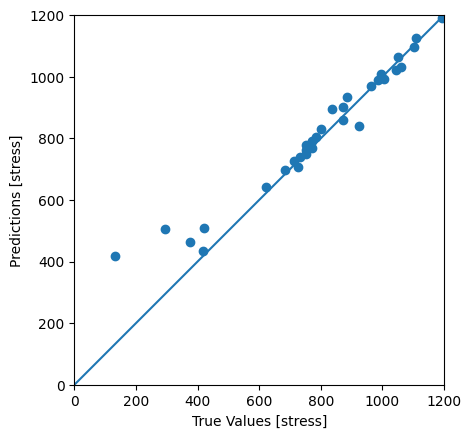

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['stress']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('True Values [stress]')
plt.ylabel('Predictions [stress]')
lims = [0, 1200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Strain rate

2/2 [==============================] - 0s 5ms/step


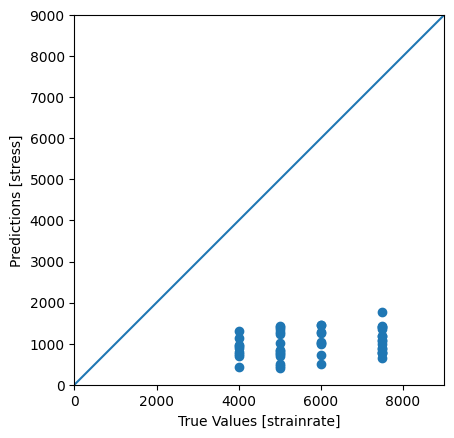

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['strainrate']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('True Values [strainrate]')
plt.ylabel('Predictions [stress]')
lims = [0, 9000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Temperature

2/2 [==============================] - 0s 3ms/step


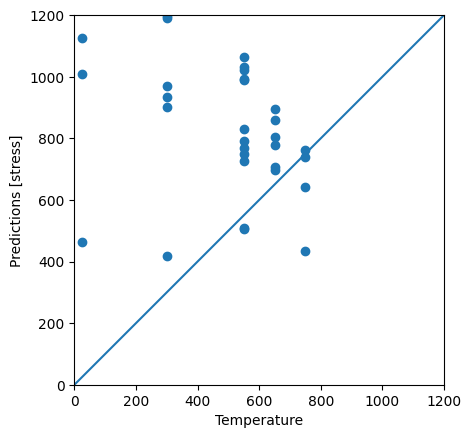

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['temperature']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('Temperature')
plt.ylabel('Predictions [stress]')
lims = [0, 1200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Strain

2/2 [==============================] - 0s 3ms/step


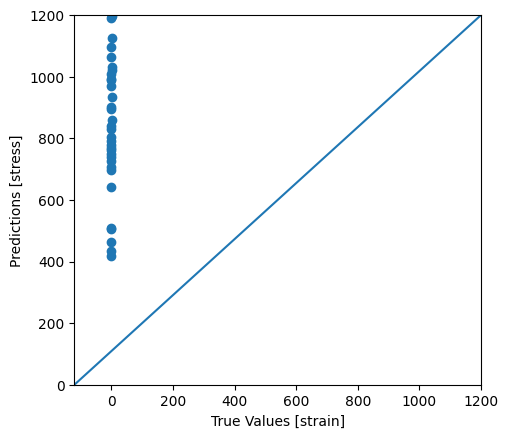

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['strain']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('True Values [strain]')
plt.ylabel('Predictions [stress]')
lims = [-120, 1200]
lim = [0,1200]
plt.xlim(lims)
plt.ylim(lim)
_ = plt.plot(lims, lim)